This tries to reconstruct image sequences in the test set

In [1]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
#_d = np.load('../data/data_128_test.npz')
_d = np.load('../data/data_128_train.npz')
X_test = _d['X']

In [3]:
X_test.shape

(5635, 128, 128)

# Finding similar images without looking at the masks

In [4]:
import skimage.util

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(16, 16))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

img = X_test[0]
compute_img_hist(img)

array([  10,   26,   55,  149,  357,  659,  513,  165,  114,    0,   20,
        140,  483,  472,  416,  212,  107,  198,   25,  197,  627,  651,
        255,  137,   47,   40,   69,   16,  373,  790,  323,  147,  129,
         68,   45,  157,   75,  366,  538,  412,  205,  149,  101,   61,
        141,   65,  277,  416,  422,  302,  231,  138,   65,  132,   26,
        289,  794,  525,  205,  133,   35,   14,   27,  137, 1018,  487,
        228,  117,   42,   17,    2,    0])

In [5]:
#hists = np.array([np.histogram(img, bins=np.linspace(0, 1, 20))[0] for img in imgs])
hists = np.array(map(compute_img_hist, X_test))
hists.shape

(5635, 72)

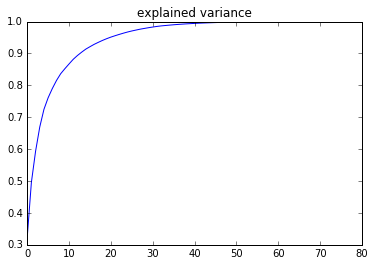

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
X_r = pca.fit_transform(hists)[:,:2]

pl.title('explained variance')
pl.plot(np.cumsum(pca.explained_variance_ratio_))

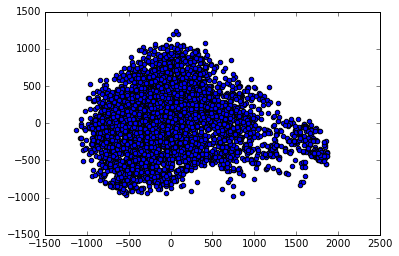

In [7]:
pl.scatter(X_r[:,0], X_r[:,1])

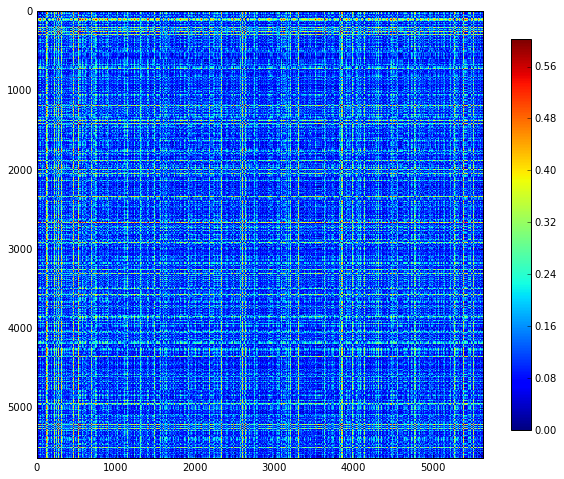

In [8]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

pl.figure(figsize=(10, 10))
pl.imshow(D, interpolation='nearest')
pl.colorbar(shrink=0.7)

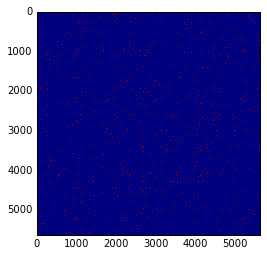

In [15]:
close_pairs = D + np.eye(D.shape[0]) < 0.03
pl.imshow(close_pairs, interpolation='nearest')

In [16]:
close_ij = np.transpose(np.nonzero(close_pairs))
print close_ij.shape

(367774, 2)


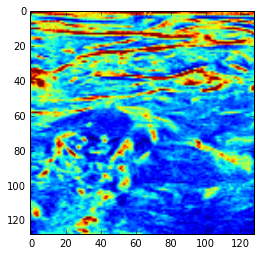

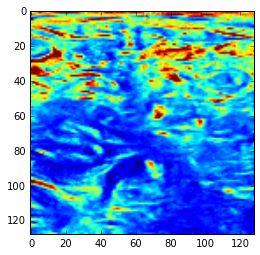

In [17]:
farthest = np.argmax(D[close_pairs])

pl.imshow(X_test[close_ij[farthest, 0]])
pl.figure()
pl.imshow(X_test[close_ij[farthest, 1]])

## Try to determine patients by building a graph

This is *VERY* sensitive to the distance threshold chosen above

In [18]:
import networkx as nx

In [19]:
G = nx.Graph()

for i in range(X_test.shape[0]):
    G.add_node(i)

for i, j in close_ij:
    G.add_edge(i, j, weight=D[i, j])

In [20]:
cc =sorted(nx.connected_components(G), key = len, reverse=True)
print len(cc)

65
